# Wine Quality Prediction - Model Training

This notebook contains the complete pipeline for:
1. Data loading and exploration
2. Data preprocessing
3. Model training and evaluation
4. Model saving


## 1. Import Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_squared_error, r2_score, mean_absolute_error
)
from sklearn.preprocessing import StandardScaler
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


## 2. Load Dataset


In [3]:
# Load the wine quality dataset
# Note: Download from https://www.kaggle.com/datasets/yasserh/wine-quality-dataset
# Place the CSV file in the data/ directory
df = pd.read_csv('../data/winequality.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
df.head()


Dataset shape: (1143, 13)

Column names: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'Id']


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


## 3. Exploratory Data Analysis


In [4]:
# Basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)
print("\nMissing Values:")
print(df.isnull().sum())
print("\n" + "="*50)
print("\nStatistical Summary:")
print(df.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB
None


Missing Values:
fixed acidity           0
volatile aci

Quality Distribution:
quality
3      6
4     33
5    483
6    462
7    143
8     16
Name: count, dtype: int64


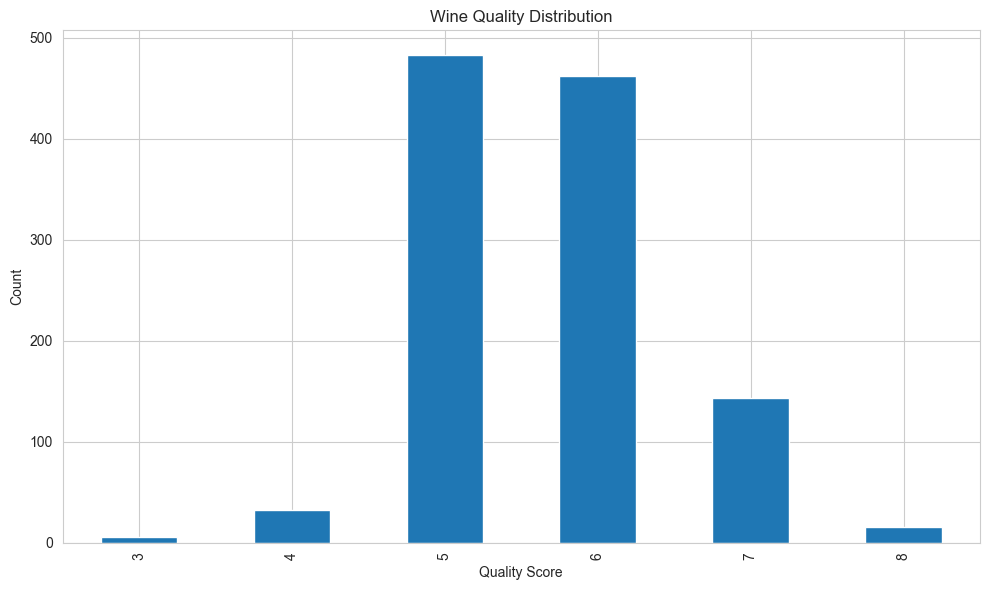

In [5]:
# Check target variable distribution
if 'quality' in df.columns:
    print("Quality Distribution:")
    print(df['quality'].value_counts().sort_index())
    
    plt.figure(figsize=(10, 6))
    df['quality'].value_counts().sort_index().plot(kind='bar')
    plt.title('Wine Quality Distribution')
    plt.xlabel('Quality Score')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('../data/quality_distribution.png')
    plt.show()


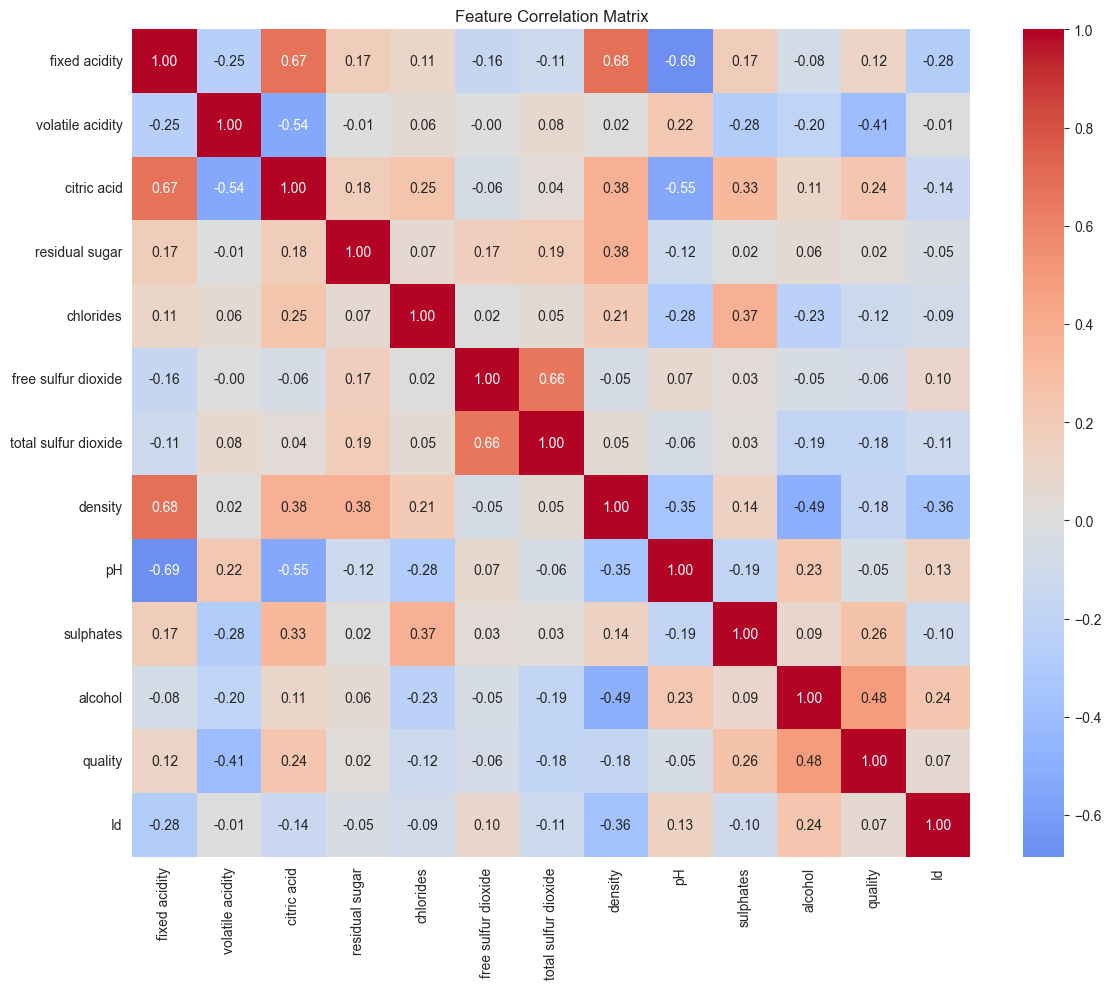

In [6]:
# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('../data/correlation_matrix.png')
plt.show()


## 4. Data Preprocessing


In [7]:
# Handle missing values
print(f"Missing values before preprocessing: {df.isnull().sum().sum()}")

# Fill missing values with median for numerical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

print(f"Missing values after preprocessing: {df.isnull().sum().sum()}")


Missing values before preprocessing: 0
Missing values after preprocessing: 0


In [8]:
# Prepare features and target
# For classification: predict quality as binary (good/bad) or multi-class
# For regression: predict quality as continuous value

# Classification approach: Convert quality to binary (>=7 = good, <7 = bad)
X = df.drop('quality', axis=1)
y_classification = (df['quality'] >= 7).astype(int)  # Binary classification
y_regression = df['quality']  # Regression target

print(f"Features shape: {X.shape}")
print(f"\nClassification target distribution:")
print(y_classification.value_counts())
print(f"\nRegression target statistics:")
print(y_regression.describe())


Features shape: (1143, 12)

Classification target distribution:
quality
0    984
1    159
Name: count, dtype: int64

Regression target statistics:
count    1143.000000
mean        5.657043
std         0.805824
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64


In [9]:
# Split data for classification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

# Split data for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_regression, test_size=0.2, random_state=42
)

print(f"Training set size (classification): {X_train_clf.shape}")
print(f"Test set size (classification): {X_test_clf.shape}")
print(f"\nTraining set size (regression): {X_train_reg.shape}")
print(f"Test set size (regression): {X_test_reg.shape}")


Training set size (classification): (914, 12)
Test set size (classification): (229, 12)

Training set size (regression): (914, 12)
Test set size (regression): (229, 12)


In [10]:
# Feature scaling
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)


## 5. Model Training - Classification


In [11]:
# Train Random Forest Classifier
print("Training Random Forest Classifier...")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_clf, y_train_clf)

# Cross-validation
cv_scores_rf = cross_val_score(rf_clf, X_train_clf, y_train_clf, cv=5, scoring='accuracy')
print(f"Random Forest CV Accuracy: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")

# Test predictions
y_pred_rf = rf_clf.predict(X_test_clf)
accuracy_rf = accuracy_score(y_test_clf, y_pred_rf)
print(f"Random Forest Test Accuracy: {accuracy_rf:.4f}")
print(f"\nClassification Report:\n{classification_report(y_test_clf, y_pred_rf)}")


Training Random Forest Classifier...
Random Forest CV Accuracy: 0.8950 (+/- 0.0479)
Random Forest Test Accuracy: 0.9170

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       197
           1       0.76      0.59      0.67        32

    accuracy                           0.92       229
   macro avg       0.85      0.78      0.81       229
weighted avg       0.91      0.92      0.91       229



In [12]:
# Train Logistic Regression
print("Training Logistic Regression...")
lr_clf = LogisticRegression(random_state=42, max_iter=1000)
lr_clf.fit(X_train_clf_scaled, y_train_clf)

# Cross-validation
cv_scores_lr = cross_val_score(lr_clf, X_train_clf_scaled, y_train_clf, cv=5, scoring='accuracy')
print(f"Logistic Regression CV Accuracy: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std() * 2:.4f})")

# Test predictions
y_pred_lr = lr_clf.predict(X_test_clf_scaled)
accuracy_lr = accuracy_score(y_test_clf, y_pred_lr)
print(f"Logistic Regression Test Accuracy: {accuracy_lr:.4f}")
print(f"\nClassification Report:\n{classification_report(y_test_clf, y_pred_lr)}")


Training Logistic Regression...
Logistic Regression CV Accuracy: 0.8753 (+/- 0.0293)
Logistic Regression Test Accuracy: 0.8690

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       197
           1       0.55      0.34      0.42        32

    accuracy                           0.87       229
   macro avg       0.72      0.65      0.67       229
weighted avg       0.85      0.87      0.86       229



In [13]:
# Train SVM Classifier
print("Training SVM Classifier...")
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train_clf_scaled, y_train_clf)

# Cross-validation
cv_scores_svm = cross_val_score(svm_clf, X_train_clf_scaled, y_train_clf, cv=5, scoring='accuracy')
print(f"SVM CV Accuracy: {cv_scores_svm.mean():.4f} (+/- {cv_scores_svm.std() * 2:.4f})")

# Test predictions
y_pred_svm = svm_clf.predict(X_test_clf_scaled)
accuracy_svm = accuracy_score(y_test_clf, y_pred_svm)
print(f"SVM Test Accuracy: {accuracy_svm:.4f}")
print(f"\nClassification Report:\n{classification_report(y_test_clf, y_pred_svm)}")


Training SVM Classifier...
SVM CV Accuracy: 0.8775 (+/- 0.0177)
SVM Test Accuracy: 0.8996

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       197
           1       0.76      0.41      0.53        32

    accuracy                           0.90       229
   macro avg       0.84      0.69      0.74       229
weighted avg       0.89      0.90      0.89       229



## 6. Model Training - Regression


In [14]:
# Train Random Forest Regressor
print("Training Random Forest Regressor...")
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_reg.fit(X_train_reg, y_train_reg)

# Cross-validation
cv_scores_rf_reg = cross_val_score(rf_reg, X_train_reg, y_train_reg, cv=5, scoring='r2')
print(f"Random Forest CV R²: {cv_scores_rf_reg.mean():.4f} (+/- {cv_scores_rf_reg.std() * 2:.4f})")

# Test predictions
y_pred_rf_reg = rf_reg.predict(X_test_reg)
mse_rf = mean_squared_error(y_test_reg, y_pred_rf_reg)
r2_rf = r2_score(y_test_reg, y_pred_rf_reg)
mae_rf = mean_absolute_error(y_test_reg, y_pred_rf_reg)
print(f"Random Forest Test R²: {r2_rf:.4f}")
print(f"Random Forest Test MSE: {mse_rf:.4f}")
print(f"Random Forest Test MAE: {mae_rf:.4f}")


Training Random Forest Regressor...
Random Forest CV R²: 0.4172 (+/- 0.1069)
Random Forest Test R²: 0.4645
Random Forest Test MSE: 0.2980
Random Forest Test MAE: 0.4109


In [15]:
# Train Linear Regression
print("Training Linear Regression...")
lr_reg = LinearRegression()
lr_reg.fit(X_train_reg_scaled, y_train_reg)

# Cross-validation
cv_scores_lr_reg = cross_val_score(lr_reg, X_train_reg_scaled, y_train_reg, cv=5, scoring='r2')
print(f"Linear Regression CV R²: {cv_scores_lr_reg.mean():.4f} (+/- {cv_scores_lr_reg.std() * 2:.4f})")

# Test predictions
y_pred_lr_reg = lr_reg.predict(X_test_reg_scaled)
mse_lr = mean_squared_error(y_test_reg, y_pred_lr_reg)
r2_lr = r2_score(y_test_reg, y_pred_lr_reg)
mae_lr = mean_absolute_error(y_test_reg, y_pred_lr_reg)
print(f"Linear Regression Test R²: {r2_lr:.4f}")
print(f"Linear Regression Test MSE: {mse_lr:.4f}")
print(f"Linear Regression Test MAE: {mae_lr:.4f}")


Training Linear Regression...
Linear Regression CV R²: 0.3541 (+/- 0.0869)
Linear Regression Test R²: 0.3128
Linear Regression Test MSE: 0.3824
Linear Regression Test MAE: 0.4800


## 7. Model Comparison and Selection


In [16]:
# Classification Model Comparison
classification_results = {
    'Random Forest': accuracy_rf,
    'Logistic Regression': accuracy_lr,
    'SVM': accuracy_svm
}

print("Classification Model Comparison:")
for model, score in sorted(classification_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {score:.4f}")

best_clf_model = max(classification_results, key=classification_results.get)
print(f"\nBest Classification Model: {best_clf_model} ({classification_results[best_clf_model]:.4f})")


Classification Model Comparison:
Random Forest: 0.9170
SVM: 0.8996
Logistic Regression: 0.8690

Best Classification Model: Random Forest (0.9170)


In [17]:
# Regression Model Comparison
regression_results = {
    'Random Forest': r2_rf,
    'Linear Regression': r2_lr
}

print("Regression Model Comparison:")
for model, score in sorted(regression_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {score:.4f}")

best_reg_model = max(regression_results, key=regression_results.get)
print(f"\nBest Regression Model: {best_reg_model} ({regression_results[best_reg_model]:.4f})")


Regression Model Comparison:
Random Forest: 0.4645
Linear Regression: 0.3128

Best Regression Model: Random Forest (0.4645)


## 8. Save Models and Preprocessors


In [18]:
# Save best classification model (Random Forest - usually performs best)
with open('../model.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)
print("Saved classification model (Random Forest) to model.pkl")

# Save scaler for classification (if needed)
with open('../scaler.pkl', 'wb') as f:
    pickle.dump(scaler_clf, f)
print("Saved scaler to scaler.pkl")

# Save feature names
with open('../feature_names.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)
print("Saved feature names to feature_names.pkl")

# Save model metadata
model_metadata = {
    'model_type': 'classification',
    'best_model': 'Random Forest',
    'accuracy': accuracy_rf,
    'cv_accuracy': cv_scores_rf.mean(),
    'feature_names': X.columns.tolist(),
    'classification_threshold': 7  # Quality >= 7 is considered good
}

with open('../model_metadata.pkl', 'wb') as f:
    pickle.dump(model_metadata, f)
print("Saved model metadata to model_metadata.pkl")


Saved classification model (Random Forest) to model.pkl
Saved scaler to scaler.pkl
Saved feature names to feature_names.pkl
Saved model metadata to model_metadata.pkl


In [19]:
# Save confusion matrix data for visualization
cm_rf = confusion_matrix(y_test_clf, y_pred_rf)
with open('../confusion_matrix.pkl', 'wb') as f:
    pickle.dump(cm_rf, f)
print("Saved confusion matrix to confusion_matrix.pkl")

# Save model comparison results
comparison_results = {
    'classification': classification_results,
    'regression': regression_results
}
with open('../model_comparison.pkl', 'wb') as f:
    pickle.dump(comparison_results, f)
print("Saved model comparison results to model_comparison.pkl")


Saved confusion matrix to confusion_matrix.pkl
Saved model comparison results to model_comparison.pkl


## 9. Feature Importance Analysis


Feature Importance:
                 feature  importance
10               alcohol    0.147784
1       volatile acidity    0.114234
2            citric acid    0.113592
9              sulphates    0.104554
7                density    0.093559
0          fixed acidity    0.071642
11                    Id    0.068414
6   total sulfur dioxide    0.063946
8                     pH    0.062451
3         residual sugar    0.054731
4              chlorides    0.053827
5    free sulfur dioxide    0.051267


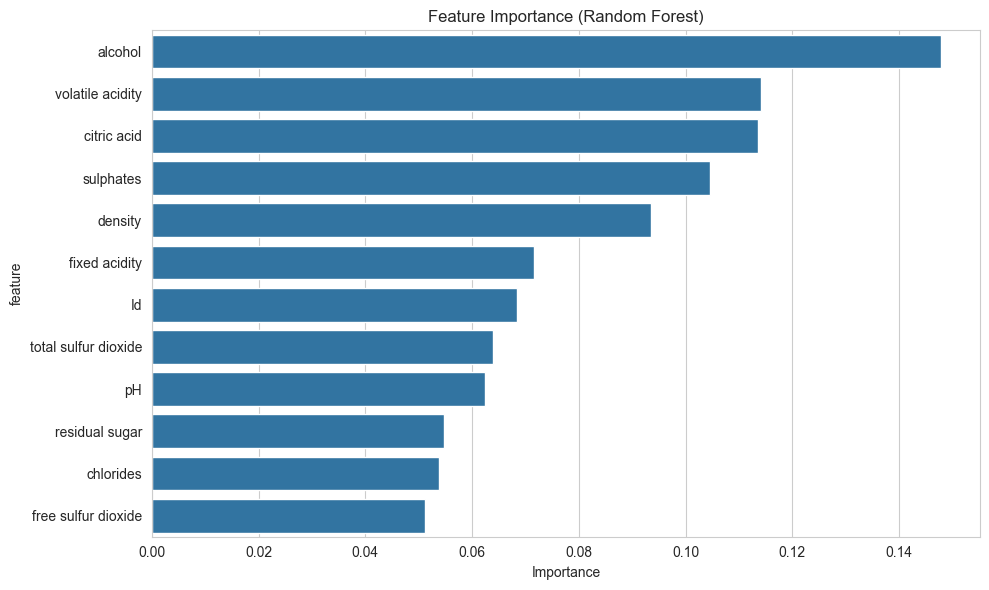

In [20]:
# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('../data/feature_importance.png')
plt.show()

# Save feature importance
feature_importance.to_csv('../data/feature_importance.csv', index=False)


## Summary

This notebook has:
1. ✅ Loaded and explored the wine quality dataset
2. ✅ Preprocessed the data (handled missing values, feature scaling)
3. ✅ Trained multiple models (Random Forest, Logistic Regression, SVM for classification; Random Forest, Linear Regression for regression)
4. ✅ Evaluated models using cross-validation and test sets
5. ✅ Selected the best model (Random Forest for classification)
6. ✅ Saved the model and necessary files for deployment
